## Imports

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.2)


In [2]:
!pip install --upgrade torch

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.0.1.post2)


In [3]:
#General
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import trange

#Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

#Data management
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

#Image processing
import cv2
from torchvision import transforms

## NN Class

In [4]:
class NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.LR = nn.LeakyReLU()
        self.c1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(32, 16, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(16, 16, 4, stride=2, padding=1)
        self.c4 = nn.Conv2d(16, 16, 4, stride=2, padding=1)
        self.c5 = nn.Conv2d(16, 16, 4, stride=2, padding=1)
        self.fc = nn.Linear(576, 8)
        
    def forward(self, x):
        
        x = self.LR(self.c1(x))
        x = self.LR(self.c2(x))
        x = self.LR(self.c3(x))
        x = self.LR(self.c4(x))
        x = self.LR(self.c5(x))
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

## Dataset Class

Image dimensions: (864, 1296, 3)

In [5]:
class APData(Dataset):
    
    def __init__(self, data_dir, label_file, extension, transform=None, resize_dims=None, device='cpu'):
        '''
        data_dir : string, the image dirctory
        extension: string, the file extnsion (with dot)
        transform: specify transforms
        resize: iterable (H, W) toreshape image to
        '''
        super().__init__()
        
        self.data_dir = data_dir
        self.labels = pd.read_json(labels_file)
        self.extension = extension
        self.transform = transform
        self.filenames = [x for x in os.listdir(data_dir) if extension.lower() in x.lower()]
        self.resize_dims = resize_dims
        self.totensor = transforms.ToTensor()
        self.device = device
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        f = self.filenames[idx]
        img = cv2.imread(self.data_dir + f)
        label = np.divide(self.labels[f][0], [1296, 864, 1296, 864, 1296, 864, 1296, 864])
        #Resize:
        if self.resize_dims != None:
            img = cv2.resize(img, self.resize_dims)
        #Transform:
        if self.transform != None:
            img = self.transform(img)
        else:
            img = self.totensor(img)
            
        return img.to(self.device), torch.tensor(label).float().to(self.device), f

## Metaparamters

In [37]:
#Data
IM_RESIZE = (200, 200)
TRAIN_RATIO = 0.9

#Training
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
N_ITERS = 100

#Directories
data_dir = "../../AP_train/Data_Training/"
labels_file = "../../AP_train/training_GT_labels2.json"

In [24]:
DEVICE

device(type='cuda', index=1)

## Load Data

In [38]:
#Transforms
transform = transforms.Compose(
    [transforms.ToTensor()])

#Create data
data = APData(data_dir, labels_file, '.jpg', transform, IM_RESIZE, DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_train, data_test = random_split(data, [train_size, len(data)-train_size])
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

## Training

In [9]:
model = NN()
#Enable cuda
model.to(DEVICE)
#Loss
criterion = nn.MSELoss()
#Optimiser
optim = torch.optim.Adam(model.parameters())
#LR Scheduler
sched = torch.optim.lr_scheduler.StepLR(optim, int(N_ITERS / 4), gamma = 0.2)

#Loss tracking
loss_arr = []

In [39]:
t = trange(N_ITERS, desc="loss: ")
for i in t:
    rec = True
    for batch in dataloader:
        
        images = batch[0]
        labels = batch[1]
        #Forward pass
        NN_out = model(images)
        loss = criterion(NN_out, labels)
        
        #Training
        optim.zero_grad()
        loss.backward()
        optim.step()
        #sched.step()
        
        loss_arr.append(loss.item())
        
        #Set the first batch loss as the loss in the tqdm description
        if rec==True:
            t.set_description("loss: {}".format(loss.item()))
            rec = False
    
plt.scatter(range(len(loss_arr[::10])), loss_arr[::10])

loss: 0.00010436423326609656:  17%|█▋        | 17/100 [54:29<4:36:31, 199.90s/it]

KeyboardInterrupt: 

## Evaluation

### Learning

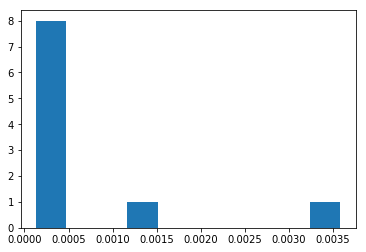

In [40]:
TEST_SIZE = 100
data_test_subset = []
for y in range(TEST_SIZE) : data_test_subset.append(data_test[y])
test_set = [x for x in DataLoader(data_test_subset, batch_size = 10)]
loss_test = []

for batch_test in test_set:
    
    images = batch_test[0]
    labels = batch_test[1]
    
    NN_out = model(images)
    loss = criterion(NN_out, labels)
    
    loss_test.append(loss.item())
    
plt.hist(loss_test, bins=10);

### Images

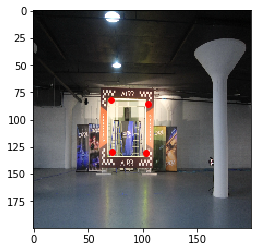

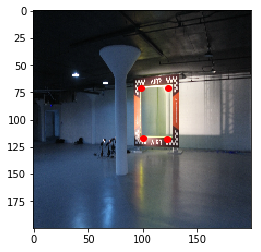

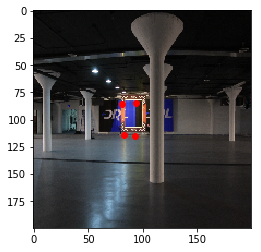

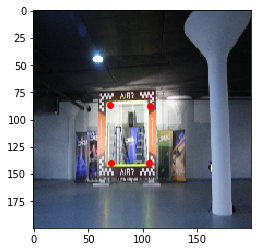

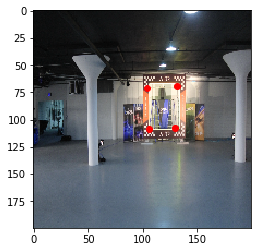

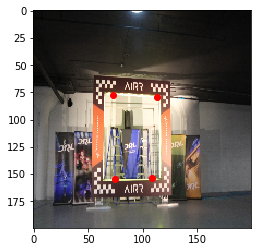

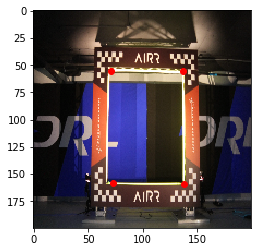

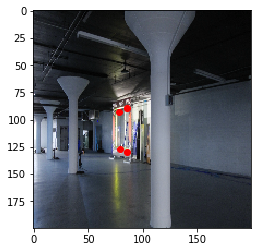

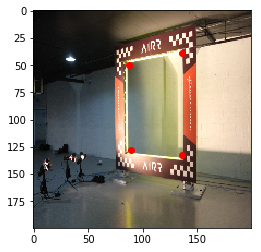

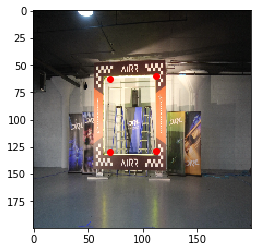

In [41]:
#Choose test data to display
batch_test = test_set[3]

#Loop through batch, displaying images with gate positions
NN_out = model(batch_test[0]).cpu().detach()
for i in range(len(batch_test[1])):
    plt.figure()
    plt.imshow(transforms.functional.to_pil_image(batch_test[0][i].cpu()))
    plt.scatter(NN_out[i][::2].numpy() * IM_RESIZE[1], NN_out[i][1::2].numpy() * IM_RESIZE[0], c='r')

In [13]:
NN_out

tensor([[0.4322, 0.5027, 0.5063, 0.4954, 0.5182, 0.7219, 0.4320, 0.7117],
        [0.3761, 0.3728, 0.5367, 0.4086, 0.5244, 0.6615, 0.3693, 0.6567],
        [0.4395, 0.4835, 0.5305, 0.4822, 0.5467, 0.6940, 0.4317, 0.6683],
        [0.3894, 0.2904, 0.5648, 0.2970, 0.5581, 0.6544, 0.3634, 0.6532]])